In [1]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')
sys.path.append('..')

# Maths
import numpy as np
from scipy.spatial import ConvexHull

# Plotting
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch
from matplotlib.patches import Rectangle, Patch
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, DivergingNorm, to_rgba

# Atoms
from ase.io import read
from ase.visualize.plot import plot_atoms
import chemiscope

# ML
from sklearn.metrics import pairwise_distances

# Utilities
import h5py
import json
import project_utils as utils
import gzip
from copy import deepcopy

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
color_list = cosmostyle.color_cycle

# Functions

In [2]:
# Compute the hull distances
def hull_distances(vprobprune, energies, projections, n_dim):
    gch_vertices = np.nonzero(vprobprune[-1])[0]
    
    vertices = np.zeros(projections.shape[0], dtype=int)
    vertices[gch_vertices] = 1
    
    vertex_energies = energies[gch_vertices]
    vertex_projections = projections[gch_vertices]
    
    ep = np.hstack((energies[:, np.newaxis], projections))
    vertex_ep = np.hstack((vertex_energies[:, np.newaxis], vertex_projections))
    
    vertex_hull = ConvexHull(vertex_ep[:, 0:n_dim])
    
    # Omit the simplices on the 'top' of the GCH
    vertex_hull_facets = np.delete(
        vertex_hull.equations,
        np.nonzero(vertex_hull.equations[:, 0] > 0.0),
        axis=0
    )
    
    hull_distance = -1.0 * (
        np.matmul(ep[:, 0:n_dim], vertex_hull_facets[:, 0:-1].T) 
        + vertex_hull_facets[:, -1]
    )
    
    hull_distance_energy = -1.0 * hull_distance / vertex_hull_facets[:, 0]
    
    hull_distance = np.amin(np.abs(hull_distance), axis=1)
    hull_distance_energy = np.amin(np.abs(hull_distance_energy), axis=1)
    
    return hull_distance, hull_distance_energy

# Load Data

In [3]:
cutoff = 6.0
spectrum = 'power'
spectrum_name = spectrum.capitalize()
group_name = 'OO+OSi+SiSi'
mixing_suffixes = ['', '_0.0', '_1.0']

In [4]:
model_dir = '../../Processed_Data/Models'

deem_name = 'DEEM_330k'
iza_name = 'IZA_230'
deem_dir = f'../../Processed_Data/{deem_name}/Data'
iza_dir = f'../../Processed_Data/{iza_name}/Data'
gch_dir = f'{model_dir}/{cutoff}/GCH/4-Class/{spectrum_name}/{group_name}'
# gch_dir = f'{model_dir}/{cutoff}/GCHTMP/4-Class/{spectrum_name}/{group_name}'

In [5]:
# Atomic structures
frames = read(f'{gch_dir}/iza+deem.xyz', index=':')

## Test and train sets

In [6]:
# Load train and test indices
deem_train_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/svm_train.idxs', dtype=int)
deem_test_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/svm_test.idxs', dtype=int)

iza_train_idxs = np.loadtxt('../../Processed_Data/IZA_230/svm_train.idxs', dtype=int)
iza_test_idxs = np.loadtxt('../../Processed_Data/IZA_230/svm_test.idxs', dtype=int)
iza_sort_test_idxs = np.argsort(iza_test_idxs)
iza_unsort_test_idxs = np.argsort(iza_sort_test_idxs)

In [7]:
# Load cantons for IZA and Deem
iza_cantons = np.loadtxt('../../Raw_Data/IZA_230/cantons.dat', usecols=1, dtype=int)[iza_test_idxs]
iza_codes = np.loadtxt('../../Raw_Data/IZA_230/cantons.dat', usecols=0, dtype=str)[iza_test_idxs]
n_iza = len(iza_codes)

deem_cantons_2 = np.loadtxt('../../Processed_Data/DEEM_330k/Data/cantons_2-class.dat', dtype=int)[deem_test_idxs]
deem_cantons_4 = np.loadtxt('../../Processed_Data/DEEM_330k/Data/cantons_4-class.dat', dtype=int)[deem_test_idxs]
deem_codes = np.arange(0, 331172) + 8000001
deem_codes = deem_codes[deem_test_idxs]
n_deem = len(deem_codes)

codes = np.concatenate((iza_codes, deem_codes))
cantons_2 = np.concatenate((np.ones(n_iza, dtype=int), deem_cantons_2))
cantons_4 = np.concatenate((iza_cantons, deem_cantons_4))

## Properties

In [8]:
# Si fractions
Si_fraction_iza = np.loadtxt('../../Raw_Data/IZA_230/compositions.dat', usecols=1)[iza_test_idxs]
Si_fraction_deem = np.ones(n_deem) / 3
Si_fraction = np.concatenate((Si_fraction_iza, Si_fraction_deem))

In [9]:
# Structure energies
deem_330k_energies = np.loadtxt('../../Processed_Data/DEEM_330k/Data/structure_energies.dat')[deem_test_idxs]
iza_energies = np.loadtxt('../../Processed_Data/IZA_230/Data/structure_energies.dat')[iza_test_idxs]
energies = np.concatenate((iza_energies, deem_330k_energies))

# Energies used in the hull construction
gch_energies = np.loadtxt(f'{gch_dir}/energies_per_si.dat')

In [10]:
# Structure volumes
deem_330k_volumes = np.loadtxt('../../Processed_Data/DEEM_330k/Data/structure_volumes.dat')[deem_test_idxs]
iza_volumes = np.loadtxt('../../Processed_Data/IZA_230/Data/structure_volumes.dat')[iza_test_idxs]
volumes = np.concatenate((iza_volumes, deem_330k_volumes))

In [11]:
# Decision functions
deem_330k_dfs_2 = np.loadtxt(
    f'{deem_dir}/{cutoff}/LSVC/2-Class/{spectrum_name}/{group_name}/svc_structure_dfs.dat'
)[deem_test_idxs]
deem_330k_dfs_4 = np.loadtxt(
    f'{deem_dir}/{cutoff}/LSVC/4-Class/{spectrum_name}/{group_name}/svc_structure_dfs.dat'
)[deem_test_idxs]

iza_dfs_2 = np.loadtxt(
    f'{iza_dir}/{cutoff}/LSVC/2-Class/{spectrum_name}/{group_name}/svc_structure_dfs.dat'
)[iza_test_idxs]
iza_dfs_4 = np.loadtxt(
    f'{iza_dir}/{cutoff}/LSVC/4-Class/{spectrum_name}/{group_name}/svc_structure_dfs.dat'
)[iza_test_idxs]

dfs_2 = np.concatenate((iza_dfs_2, deem_330k_dfs_2))
dfs_4 = np.concatenate((iza_dfs_4, deem_330k_dfs_4))

In [12]:
dfs = dfs_2

In [13]:
# 4-Class cantons
predicted_deem_cantons_2 = np.loadtxt(
    f'{deem_dir}/{cutoff}/LSVC/2-Class/{spectrum_name}/{group_name}/svc_structure_cantons.dat', dtype=int
)[deem_test_idxs]
predicted_deem_cantons_4 = np.loadtxt(
    f'{deem_dir}/{cutoff}/LSVC/4-Class/{spectrum_name}/{group_name}/svc_structure_cantons.dat', dtype=int
)[deem_test_idxs]

predicted_iza_cantons_2 = np.loadtxt(
    f'{iza_dir}/{cutoff}/LSVC/2-Class/{spectrum_name}/{group_name}/svc_structure_cantons.dat', dtype=int
)[iza_test_idxs]
predicted_iza_cantons_4 = np.loadtxt(
    f'{iza_dir}/{cutoff}/LSVC/4-Class/{spectrum_name}/{group_name}/svc_structure_cantons.dat', dtype=int
)[iza_test_idxs]

predicted_cantons_2 = np.concatenate((predicted_iza_cantons_2, predicted_deem_cantons_2))
predicted_cantons_4 = np.concatenate((predicted_iza_cantons_4, predicted_deem_cantons_4))

In [14]:
np.all(np.argmax(deem_330k_dfs_4, axis=1)+1 == predicted_deem_cantons_4)

True

# GCH

In [15]:
# TODO: analysis for all GCH's (different PCovR mixing)

In [16]:
mixing = ''

In [17]:
# Hull distances (TODO: change this so we just save all the useful properties from the GCH notebook)
vprobprune = np.loadtxt(f'{gch_dir}/rattled{mixing}/vprobprune.dat')
T = np.loadtxt(f'{gch_dir}/T{mixing}.dat')
ndim = 3

d, de = hull_distances(vprobprune, gch_energies, T, ndim)

In [18]:
gch_vertices = np.nonzero(vprobprune[-1])[0]
iza_vertices = gch_vertices[gch_vertices < n_iza]
deem_vertices = gch_vertices[gch_vertices >= n_iza]

vertex_indicators = np.zeros(T.shape[0], dtype=int)
vertex_indicators[gch_vertices] = 1

## Check rattled structures

In [19]:
T_rattled = np.loadtxt(f'{gch_dir}/rattled{mixing}/T{mixing}.dat')
ref_idxs = np.loadtxt(f'{gch_dir}/rattled{mixing}/refstruct.idx', dtype=int)

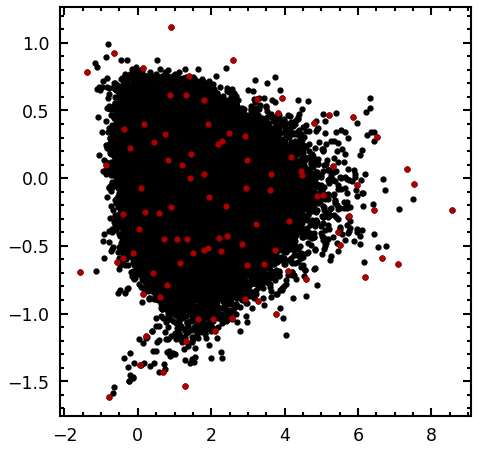

In [20]:
plt.scatter(T[:, 0], T[:, 1])
plt.scatter(T[ref_idxs, 0], T[ref_idxs, 1])
plt.show()

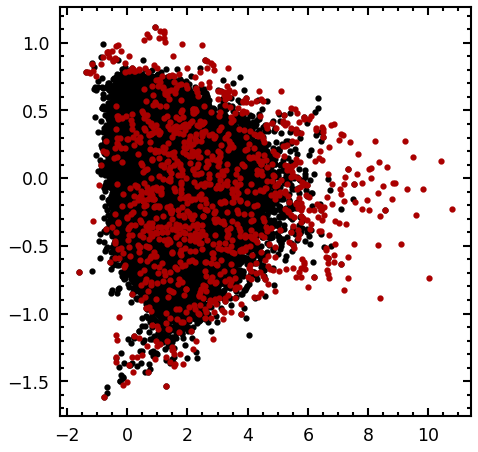

In [21]:
plt.scatter(T[:, 0], T[:, 1])
plt.scatter(T_rattled[:, 0], T_rattled[:, 1])
plt.show()

## Plot GCH

In [22]:
def histogram(X, Y, bins, return_edges=False):
    Z, X_edges, Y_edges = np.histogram2d(X, Y, bins=bins, density=True)
    dX = np.diff(X_edges)
    dY = np.diff(Y_edges)
    X_centers = X_edges[0:-1]
    Y_centers = Y_edges[0:-1]
    X_centers += dX / 2
    Y_centers += dY / 2
    X, Y = np.meshgrid(X_centers, Y_centers)
    
    if return_edges:
        return X, Y, Z.T, X_edges, Y_edges
    else:
        return X, Y, Z.T
    
def logbase(x, base):
    return np.log10(x) / np.log10(base)
    
def scale_points(data, min_value, max_value, inverted=False, log=False, base=10):
    normalized_data = (data - np.amin(data)) / (np.amax(data) - np.amin(data))
    if inverted:
        normalized_data = 1.0 - normalized_data
    
    if log:
        scaled_data = base ** (
            normalized_data * (
                logbase(max_value, base) - logbase(min_value, base)
            ) + logbase(min_value, base)
        )
    else:
        scaled_data =  normalized_data * (max_value - min_value) + min_value

    return scaled_data

In [23]:
frames_deem_vertices = [frames[idx] for idx in deem_vertices]
frames_iza_vertices = [frames[idx] for idx in iza_vertices]

In [24]:
base = 10
size_min = 1
size_max = 50
alpha_min = 0.01
alpha_max = 1.0
sizes = scale_points(de, size_min, size_max, inverted=True, log=True, base=base)
alphas = scale_points(de, alpha_min, alpha_max, inverted=True, log=True, base=base)

df_limits = np.abs([np.amin(dfs), np.amax(dfs)])
df_idx = np.argmin(df_limits)
df_limit = df_limits[df_idx]
if df_idx == 0:
    extend_key = 'max'
else:
    extend_key = 'min'
extend_key = 'neither'

# vmin = -df_limit
vmin = np.amin(dfs)
# vmax = df_limit
vmax = np.amax(dfs)

norm = DivergingNorm(vcenter=0.0, vmin=vmin, vmax=vmax)
color_map = ScalarMappable(norm=norm, cmap='RdBu')
colors = color_map.to_rgba(dfs, alpha=1.0)
colors[:, -1] = alphas

ecolors = np.tile(to_rgba(color_list[0]), (len(colors), 1))
ecolors[:, -1] = alphas

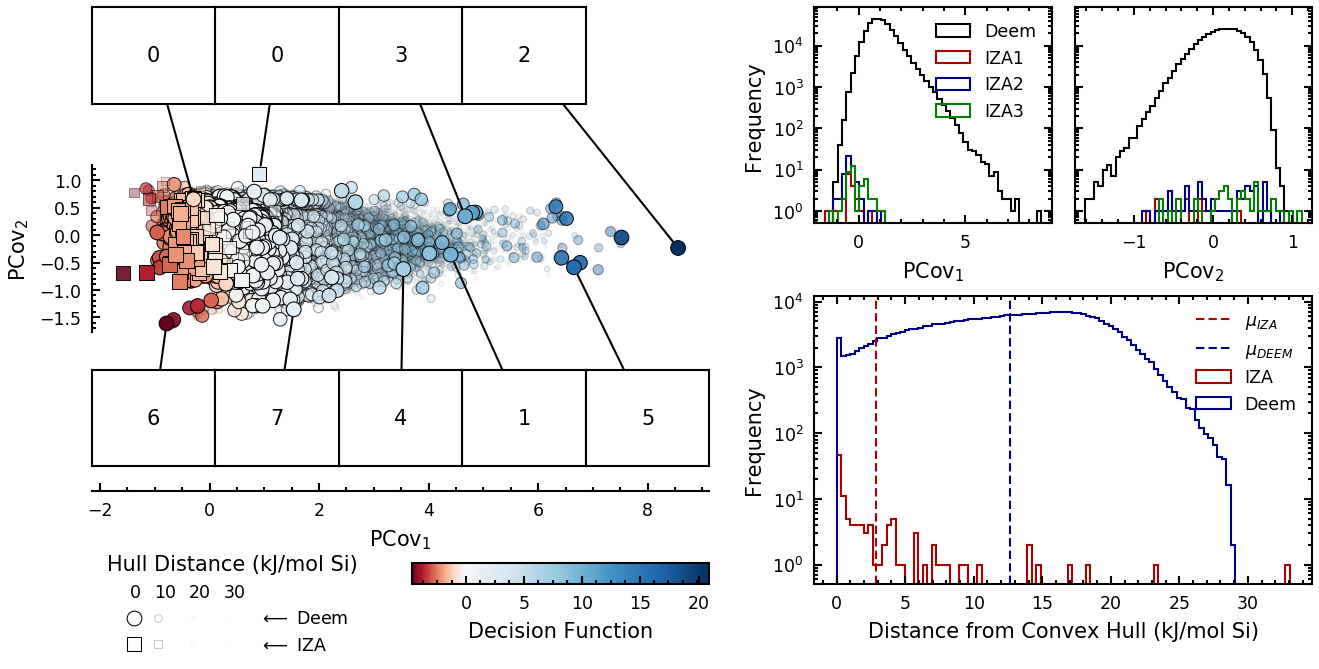

In [25]:
# TODO: highlight the 4 archetypes: IZA-like IZA, IZA-like Deem, Deem-like IZA, Deem-like Deem
fig = plt.figure(figsize=(10.5, 5.0))
gs = fig.add_gridspec(
    nrows=3, ncols=5,
    width_ratios=(1.0, 1.0, 0.20, 0.8, 0.8), height_ratios=(1.0, 0.90, 0.10),
    wspace=0.10, hspace=0.50
)

# GCH
axs = fig.add_subplot(gs[0:-1, 0:2])
axs.set_aspect(aspect='equal', anchor='W', adjustable='datalim')
axs_hull = fig.add_subplot(gs[1:, -2:])
caxs = fig.add_subplot(gs[-1, 1])
pcovr_axes = [fig.add_subplot(gs[0, i]) for i in range(-2, 0)]
pcovr_grouper = pcovr_axes[0].get_shared_y_axes()
for ax in pcovr_axes[1:]:
    pcovr_grouper.join(ax, pcovr_axes[0])
    ax.tick_params(labelleft=False)

T_iza = np.delete(T[0:n_iza], iza_vertices, axis=0)
de_iza = np.delete(de[0:n_iza], iza_vertices)
df_iza = np.delete(dfs[0:n_iza], iza_vertices)
s_iza = np.delete(sizes[0:n_iza], iza_vertices)
colors_iza = np.delete(colors[0:n_iza], iza_vertices, axis=0)
ecolors_iza = np.delete(ecolors[0:n_iza], iza_vertices, axis=0)
po_iza = np.flip(np.argsort(de_iza))

T_deem = np.delete(T[n_iza:], deem_vertices - n_iza, axis=0)
de_deem = np.delete(de[n_iza:], deem_vertices - n_iza)
df_deem = np.delete(dfs[n_iza:], deem_vertices - n_iza)
s_deem = np.delete(sizes[n_iza:], deem_vertices - n_iza)
colors_deem = np.delete(colors[n_iza:], deem_vertices - n_iza, axis=0)
ecolors_deem = np.delete(ecolors[n_iza:], deem_vertices - n_iza, axis=0)
po_deem = np.flip(np.argsort(de_deem))

T_iza_vertices = T[iza_vertices]
de_iza_vertices = de[iza_vertices]
df_iza_vertices = dfs[iza_vertices]
s_iza_vertices = sizes[iza_vertices]
colors_iza_vertices = colors[iza_vertices]
ecolors_iza_vertices = ecolors[iza_vertices]

T_deem_vertices = T[deem_vertices]
de_deem_vertices = de[deem_vertices]
df_deem_vertices = dfs[deem_vertices]
s_deem_vertices = sizes[deem_vertices]
colors_deem_vertices = colors[deem_vertices]
ecolors_deem_vertices = ecolors[deem_vertices]

# Deem
deem_pts = axs.scatter(
    T_deem[po_deem, 0], T_deem[po_deem, 1],
    c=colors_deem[po_deem],
    marker='o', edgecolor=ecolors_deem[po_deem], linewidth=0.5, s=s_deem[po_deem],
    rasterized=True
)
# IZA
iza_pts = axs.scatter(
    T_iza[po_iza, 0], T_iza[po_iza, 1],
    c=colors_iza[po_iza],
    marker='s', edgecolor=ecolors_iza[po_iza], linewidth=0.5, s=s_iza[po_iza],
    rasterized=True
)

# Deem vertices
axs.scatter(
    T_deem_vertices[:, 0], T_deem_vertices[:, 1],
    c=colors_deem_vertices,
    marker='o', edgecolor=ecolors_deem_vertices, linewidth=0.5, s=s_deem_vertices,
    zorder=3,
    rasterized=True
)

# IZA vertices
axs.scatter(
    T_iza_vertices[:, 0], T_iza_vertices[:, 1],
    c=colors_iza_vertices,
    marker='s', edgecolor=ecolors_iza_vertices, linewidth=0.5, s=s_iza_vertices,
    zorder=3,
    rasterized=True
)

cb = fig.colorbar(
    color_map, cax=caxs, label='Decision Function', orientation='horizontal', extend=extend_key
)

axs.set_xlabel(r'PCov$_1$')
axs.set_ylabel(r'PCov$_2$')

xcenter = 0.0
xlim = axs.get_xlim()
xticks = axs.get_xticks()
xticks_minor = axs.get_xticks(minor=True)
xticklabels = axs.get_xticklabels()

ycenter = 0.0
ylim = axs.get_ylim()
yticks = axs.get_yticks()
yticks_minor = axs.get_yticks(minor=True)
yticklabels = axs.get_yticklabels()

axs.set_xticks(xticks[1:-1]) # We seem to have extra major ticks at the limits
axs.set_xticks(xticks_minor, minor=True)

axs.set_yticks(yticks[1:-1]) # We seem to have extra major ticks at the limits
axs.set_yticks(yticks_minor, minor=True)

axs.spines['left'].set_bounds(*ylim)
axs.spines['bottom'].set_bounds(*xlim)

axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.tick_params(which='both', axis='both', top=False, right=False)

legend_distances = np.linspace(int(np.amin(de)), 10*int(np.amax(de) // 10), 4, dtype=int)
legend_sizes = scale_points(legend_distances, size_min, size_max, inverted=True, log=True, base=base)
legend_alphas = scale_points(legend_distances, alpha_min, alpha_max, inverted=True, log=True, base=base)

legend_patches = []
for legend_distance, legend_size, legend_alpha in zip(legend_distances, legend_sizes, legend_alphas):
    legend_patches.append(Line2D(
        [0], [0],
        linewidth=0.0,
        markersize=0.0,
        label=legend_distance
    ))
    for marker in ('o', 's'):
        legend_patches.append(Line2D(
            [0], [0],
            linewidth=0.0,
            marker=marker, markerfacecolor='w', 
            markeredgecolor=color_list[0], markeredgewidth=0.5,
            alpha=legend_alpha, markersize=np.sqrt(legend_size),
        ))

for label in ('', r'$\longleftarrow$ Deem', r'$\longleftarrow$ IZA'):
    legend_patches.append(Line2D([0], [0], linewidth=0.0, markersize=0.0, label=label))
    
legend = axs.legend(
    handles=legend_patches, 
    title='Hull Distance (kJ/mol Si)',
    loc='upper left', bbox_to_anchor=(0.0, -0.10),
    ncol=len(legend_patches) // 3,
    handletextpad=-1.25,
    columnspacing=0.0
)

#for legend_text in legend.get_texts()[1:-1:2]:
#    legend_text.set_visible(False)

#deem_inset_positions = [t + np.array([0.5, 0.5]) for t in T_deem_vertices[:, 0:2]]
deem_inset_positions = np.array([
    [0.0, 0.8],
    [0.6, 0.05],
    [0.6, 0.8],
    [0.4, 0.8],
    [0.4, 0.05],
    [0.8, 0.05],
    [0.0, 0.05],
    [0.2, 0.05]
])
iza_inset_positions = np.array([
    [0.2, 0.8],
])

#deem_inset_positions += T_deem_vertices[:, 0:2]
#deem_inset_positions = axs.transLimits.transform(deem_inset_positions)

#iza_inset_positions += T_iza_vertices[:, 0:2]
#iza_inset_positions = axs.transLimits.transform(iza_inset_positions)

inset_size = [0.2, 0.2]

for vertex_frames, color, vertices, inset_positions in zip(
    (frames_iza_vertices, frames_deem_vertices),
    (color_list[0], color_list[0]),
    (T_iza_vertices[:, 0:2], T_deem_vertices[:, 0:2]),
    (iza_inset_positions, deem_inset_positions)
):
    for vdx, (vertex, inset_position, frame) in enumerate(zip(vertices, inset_positions, vertex_frames)):
        axs_inset = axs.inset_axes([*inset_position, *inset_size])
        #plot_atoms(frame, axs_inset)
        axs_inset_center = np.array(inset_position) + np.array(inset_size) / 2
        
        axs.annotate(
            '',
            xy=vertex,
            xytext=axs_inset_center,
            xycoords=axs.transData,
            textcoords=axs.transAxes,
            arrowprops=dict(arrowstyle='-', color=color, shrinkB=4)
        )
        axs_inset.tick_params(
            which='both', axis='both', 
            left=False, bottom=False, right=False, top=False,
            labelleft=False, labelbottom=False, labelright=False, labeltop=False
        )
        
        axs_inset.text(
            0.5, 0.5,
            vdx,
            horizontalalignment='center', verticalalignment='center',
            transform=axs_inset.transAxes,
        )

# PCovR HISTOGRAMS
histogram_max = np.amax(T, axis=0)
histogram_min = np.amin(T, axis=0)
pcovr_histogram_parameters = dict(bins=50, density=False, log=True, histtype='step')

for pc, pcovr_axs in enumerate(pcovr_axes):
    histogram_range = (histogram_min[pc], histogram_max[pc])

    pcovr_axs.hist(
        T[n_iza:, pc], 
        range=histogram_range, 
        **pcovr_histogram_parameters, label='Deem'
    )
    
    for i in range(1, np.amax(iza_cantons)+1):
        canton_idxs = np.nonzero(iza_cantons == i)[0]
        
        pcovr_axs.hist(
            T[0:n_iza, pc][canton_idxs], 
            range=histogram_range, 
            **pcovr_histogram_parameters, label=f'IZA{i}'
        )
            
    if pc == 0:
        pcovr_axs.set_ylabel('Frequency')
        
    pcovr_axs.set_xlabel(fr'PCov$_{{{pc+1}}}$')
    pcovr_axs.set_ylim((0.5, pcovr_axs.get_ylim()[1]))

pcovr_axes[0].legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))

# HULL HISTOGRAM
# TODO: how to make the scale the same as the energies in the PCA plot, since those include RWY?
hull_histogram_parameters = dict(
    range=(np.amin(de), np.amax(de)),
    density=False, bins=100, log=True,
)

axs_hull.hist(
    de[0:n_iza], **hull_histogram_parameters, 
    color=color_list[1], histtype='step', label='IZA'
)
axs_hull.axvline(
    np.mean(de[0:n_iza]), 
    color=color_list[1], linestyle='--', label=r'$\mu_{IZA}$'
)

axs_hull.hist(
    de[n_iza:], 
    **hull_histogram_parameters, 
    color=color_list[2], histtype='step', label='Deem'
)
axs_hull.axvline(
    np.mean(de[n_iza:]), 
    color=color_list[2], linestyle='--', label=r'$\mu_{DEEM}$'
)

axs_hull.set_ylabel('Frequency')
axs_hull.set_xlabel('Distance from Convex Hull (kJ/mol Si)')
axs_hull.set_ylim((0.5, axs_hull.get_ylim()[1]))

axs_hull.legend()

fig.savefig(f'../../Results/{cutoff}/gch_{cutoff}_{spectrum}_{group_name}{mixing}.pdf', bbox_inches='tight')

plt.show()

In [26]:
gch_vertices

array([    21, 112623, 125344, 125533, 143441, 149700, 166512, 274947,
       292600])

# Hull stats

In [27]:
print(np.argmax(de), np.amax(de))

33 33.05825273674254


In [28]:
iza_de = np.argsort(de)
iza_de = iza_de[iza_de < n_iza]
for dist, code, canton in zip(
    de[iza_de], 
    iza_codes[iza_de], 
    iza_cantons[iza_de]
):
    print(f'{code}\t{canton}\t{dist}')

BSV	3	0.0
YFI	2	0.005559581517652367
TER	2	0.011413306823998631
TON	2	0.01153425886927902
AVE	3	0.015577395082941817
AFI	3	0.017906288097307984
PTT	2	0.03336686929831786
MRT	2	0.035518305000476855
APD	3	0.04270914625889305
IHW	1	0.04465105717301926
SAF	3	0.04625202166120072
ATT	3	0.05149362231856943
MEP	1	0.06766473282532677
VET	1	0.0741835853113702
SIV	3	0.07723648600512839
MSE	2	0.09918637086647217
MEL	2	0.10395599333928407
SGT	1	0.1052666066101884
ITE	1	0.11971296014797542
AEI	3	0.12382106732163582
DDR	1	0.12861084583551585
RTH	2	0.13057056138239795
BOG	2	0.13399178481701132
ATV	3	0.1403271192384605
PHI	2	0.14318421520539934
MSO	2	0.15074119302865188
LEV	2	0.1613795994379565
MWF	2	0.16403243922268154
SZR	2	0.1699377717828545
BRE	2	0.18288149910952708
SFG	2	0.22011229787927478
BOF	3	0.22607008409105994
SVV	2	0.226794730584659
IFW	2	0.2377436354514884
PSI	3	0.24476307012943233
MTT	2	0.2475664137829974
GIS	2	0.2476193303448817
MTW	2	0.26353561637169615
AWW	3	0.2647821651876866
NSI	1	0.

In [29]:
canton_1_idxs = np.nonzero(iza_cantons == 1)[0]
iza_de = np.argsort(de[canton_1_idxs])
for dist, code, canton in zip(
    de[canton_1_idxs][iza_de], iza_codes[canton_1_idxs][iza_de], iza_cantons[canton_1_idxs][iza_de]
):
    print(f'{code}\t{canton}\t{dist}')

IHW	1	0.04465105717301926
MEP	1	0.06766473282532677
VET	1	0.0741835853113702
SGT	1	0.1052666066101884
ITE	1	0.11971296014797542
DDR	1	0.12861084583551585
NSI	1	0.26544956977606904
PCR	1	0.36185257074471855
ITH	1	0.3782760013150207
NON	1	0.5332091261528703
MTN	1	0.9149640945242626
STF	1	1.045041161798268
CFI	1	1.0643322525907912
RRO	1	1.511841491276772
LTF	1	1.7148582422940883
OKO	1	2.0515401194512015
IFR	1	2.584756314361324
CSV	1	2.668754284212904


In [30]:
de_limit = de[canton_1_idxs][iza_de][-1]
print(de_limit)

2.668754284212904


## SVM-based candidates

In [31]:
def k_nearest_neighbors(A, B, y, k=1):
    """
        Computes the property y' for dataset A
        based on the average of properties y of 
        the k closest instances of dataset B 
        (Euclidean distance)
        
        ---Arguments---
        A: dataset with unknown properties
        B: "reference" dataset with known properties
        y: known properties of dataset B
        k: number of nearest neighbors
        
        ---Returns---
        yy: k-nearest-neighbor properties for dataset A
    """
    
    if A.ndim == 1:
        A = np.reshape(A, (-1, 1))
    if B.ndim == 1:
        B = np.reshape(B, (1, -1))
        
    D = pairwise_distances(A, B, metric='euclidean')
    idxs = np.argsort(D, axis=1)[:, 0:k]
    yy = np.mean(y[idxs], axis=1)
    return yy

In [32]:
most_iza_deem_idxs = np.argsort(deem_330k_dfs_2)
most_iza_iza_idxs = np.argsort(iza_dfs_2)

In [33]:
n_select = 5

In [34]:
# Most IZA-like Deem
most_iza_idxs = most_iza_deem_idxs[0:n_select]
most_iza_soap_idxs = deem_codes[most_iza_idxs] - 8000001
most_iza_sort_idxs = np.argsort(most_iza_soap_idxs)
most_iza_unsort_idxs = np.argsort(most_iza_sort_idxs)

print(deem_codes[most_iza_idxs])
print(deem_330k_dfs_2[most_iza_idxs])
print(Si_fraction_deem[most_iza_idxs])

# Load SOAPs
deem_soaps = utils.load_hdf5(
    f'{deem_dir}/{cutoff}/soaps_power_full_avg_nonorm.hdf5', indices=most_iza_soap_idxs[most_iza_sort_idxs]
)[most_iza_unsort_idxs]

iza_soaps = utils.load_hdf5(
    f'{iza_dir}/{cutoff}/soaps_power_full_avg_nonorm.hdf5', indices=iza_test_idxs[iza_sort_test_idxs]
)[iza_unsort_test_idxs]

predicted_Si_fraction = k_nearest_neighbors(deem_soaps, iza_soaps, Si_fraction_iza, k=1)
print(predicted_Si_fraction.squeeze())

[8283748 8162065 8204697 8162069 8054476]
[-4.57260927 -4.24186819 -4.10678037 -3.89826663 -3.55224275]
[0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]
[0.33333 0.33333 0.33333 0.33333 0.     ]


In [35]:
# Most Deem-like Deem
most_deem_idxs = most_iza_deem_idxs[-n_select:]
print(deem_codes[most_deem_idxs])
print(deem_330k_dfs_2[most_deem_idxs])
print(Si_fraction_deem[most_deem_idxs])

[8229490 8187831 8054203 8126142 8129504]
[17.26236124 17.33338884 17.97300412 18.20192276 20.91711481]
[0.33333333 0.33333333 0.33333333 0.33333333 0.33333333]


In [36]:
# Most IZA-like IZA
most_iza_idxs = most_iza_iza_idxs[0:n_select]
print(iza_codes[most_iza_idxs])
print(iza_dfs_2[most_iza_idxs])
print(Si_fraction_iza[most_iza_idxs])

['MTN' 'SBN' 'MEP' 'NAT' 'VSV']
[-4.60840191 -4.20661498 -3.60998424 -3.35044084 -3.28654155]
[0.33333 0.      0.33333 0.2     0.25926]


In [37]:
# Most Deem-like IZA
most_deem_idxs = most_iza_iza_idxs[-n_select:]
print(iza_codes[most_deem_idxs])
print(iza_dfs_2[most_deem_idxs])
print(Si_fraction_iza[most_deem_idxs])

['APC' 'SOS' 'BCT' 'BSV' 'CZP']
[1.1724671  1.39054576 1.93543046 2.36617566 2.60680398]
[0.      0.      0.23833 0.      0.     ]


## GCH-based candidates

In [38]:
gch_vertices_de = np.nonzero(de <= de_limit)[0]
iza_vertices_de = gch_vertices_de[gch_vertices_de < n_iza]
deem_vertices_de = gch_vertices_de[gch_vertices_de >= n_iza]

In [39]:
# Vertex structures
print('=== IZA candidates ===')
iza_candidates = iza_codes[iza_vertices]
n_iza_candidates = len(iza_candidates)
print(n_iza_candidates)
print(iza_candidates)
print(df_iza_vertices)

print('=== Deem candidates ===')
deem_candidates = deem_codes[deem_vertices - n_iza]
n_deem_candidates = len(deem_candidates)
print(n_deem_candidates)
print(deem_candidates)
print(df_deem_vertices)

=== IZA candidates ===
1
['BSV']
[2.36617566]
=== Deem candidates ===
8
[8116170 8129309 8129504 8147992 8154453 8171811 8283748 8301974]
[-0.98320394  9.85582466 20.91711481 10.31782603  7.30970499 15.89000814
 -4.57260927  2.08733619]


In [40]:
# Structures within de_limit of hull
print('=== IZA candidates ===')
iza_candidates = iza_codes[iza_vertices_de]
n_iza_candidates = len(iza_candidates)
print(n_iza_candidates)
print(iza_candidates)

print('=== Deem candidates ===')
deem_candidates = deem_codes[deem_vertices_de - n_iza]
n_deem_candidates = len(deem_candidates)
print(n_deem_candidates)
print(deem_candidates)

=== IZA candidates ===
82
['TER' 'SVV' 'AFV' 'GIS' 'ATV' 'MSE' 'UTL' 'MRT' 'NSI' 'PTY' 'AFX' 'APC'
 'YFI' 'SGT' 'ITH' 'CFI' 'BSV' 'MTT' 'YUG' 'AWO' 'IHW' 'APD' 'PTT' 'PHI'
 'EUO' 'AWW' 'PWN' 'SOV' 'RUT' 'OFF' 'SAV' 'RTH' 'MSO' 'PCR' 'IFR' 'BOF'
 'PSI' 'AFI' 'OKO' 'ATO' 'SEW' 'AVL' 'MEP' 'LTF' 'TON' 'SZR' 'AEN' 'MTW'
 'ETV' 'DFT' 'SIV' 'PWW' 'SFG' 'ITG' 'STF' 'AVE' 'MEL' 'AEI' 'VET' 'MFS'
 'NON' 'GIU' 'BRE' 'ITE' 'BOG' 'MTN' 'SAF' 'LOS' 'EWO' 'IFW' 'DDR' 'LEV'
 'KFI' 'PON' 'CSV' 'JSN' 'RRO' 'FRA' 'SFO' 'LAU' 'MWF' 'ATT']
=== Deem candidates ===
15751
[8000060 8000118 8000156 ... 8331158 8331169 8331171]


In [41]:
# Searching top x% of structures
search_fraction = 0.05
n_search_iza = int(search_fraction * n_iza)
n_search_deem = int(search_fraction * n_deem)

# IZA-like DEEM
id_intersect = np.intersect1d(
    deem_codes[deem_vertices - n_iza], deem_codes[most_iza_deem_idxs[0:n_search_deem]]
)
n_id = len(id_intersect)
print('=== IZA-like Deem ===')
print(n_id / n_search_deem)
print(id_intersect)

# IZA-like IZA
ii_intersect = np.intersect1d(
    iza_codes[iza_vertices], iza_codes[most_iza_iza_idxs[0:n_search_iza]]
)
n_ii = len(ii_intersect)
print('=== IZA-like IZA ===')
print(n_ii / n_search_iza)
print(ii_intersect)

# DEEM-like IZA
di_intersect = np.intersect1d(
    iza_codes[iza_vertices], iza_codes[most_iza_iza_idxs[-n_search_iza:]]
)
n_di = len(di_intersect)
print('=== Deem-like IZA ===')
print(n_di / n_search_iza)
print(di_intersect)

# DEEM-like DEEM
dd_intersect = np.intersect1d(
    deem_codes[deem_vertices - n_iza], deem_codes[most_iza_deem_idxs[-n_search_deem:]]
)
n_dd = len(dd_intersect)
print('=== Deem-like Deem ===')
print(n_dd / n_search_deem)
print(dd_intersect)

print(f'Total Deem: {n_id + n_dd}')
print(f'Total IZA: {n_di + n_ii}')

=== IZA-like Deem ===
0.00012457954403886882
[8116170 8283748]
=== IZA-like IZA ===
0.0
[]
=== Deem-like IZA ===
0.2
['BSV']
=== Deem-like Deem ===
0.00031144886009717206
[8129309 8129504 8147992 8154453 8171811]
Total Deem: 7
Total IZA: 1


In [42]:
iza_df = np.argsort(iza_dfs_2[canton_1_idxs])
for dist, code, canton in zip(
    iza_dfs_2[canton_1_idxs][iza_df], 
    iza_codes[canton_1_idxs][iza_df], 
    iza_cantons[canton_1_idxs][iza_df]
):
    print(f'{code[-3:]}\t{canton}\t{dist}')

MTN	1	-4.608401910920785
MEP	1	-3.60998424248937
NON	1	-2.1872720029054578
PCR	1	-1.9857278222426222
NSI	1	-1.9391509685308752
CSV	1	-1.7015769714304545
STF	1	-1.6667514943072184
RRO	1	-1.4527566121618678
ITH	1	-1.416915838341258
LTF	1	-1.3970640580766172
DDR	1	-1.3694557318600509
ITE	1	-1.359187129741813
CFI	1	-1.2351471120490252
SGT	1	-1.0989928883364866
OKO	1	-0.9894982037623175
IHW	1	-0.5960003507563272
IFR	1	-0.5776912485956407
VET	1	0.5316298010637496


In [43]:
df_limit = np.amax(iza_dfs_2[canton_1_idxs])
print(df_limit)

0.5316298010637496


In [44]:
gch_vertices_df = np.nonzero(dfs <= df_limit)[0]
iza_vertices_df = gch_vertices_df[gch_vertices_df < n_iza]
deem_vertices_df = gch_vertices_df[gch_vertices_df >= n_iza]

In [45]:
gch_vertices_df_de = np.intersect1d(gch_vertices_de, gch_vertices_df)
iza_vertices_df_de = gch_vertices_df_de[gch_vertices_df_de < n_iza]
deem_vertices_df_de = gch_vertices_df_de[gch_vertices_df_de >= n_iza]

In [46]:
# Structures within df_limit (most Deem-like IZA1)
print('=== IZA candidates ===')
iza_candidates = iza_codes[iza_vertices_df]
n_iza_candidates = len(iza_candidates)
print(n_iza_candidates)
print(iza_candidates)

print('=== Deem candidates ===')
deem_candidates = deem_codes[deem_vertices_df - n_iza]
n_deem_candidates = len(deem_candidates)
print(n_deem_candidates)
print(deem_candidates)

=== IZA candidates ===
104
['WEI' 'TER' 'SVV' 'AFV' 'MEI' 'GIS' 'ATV' 'MSE' 'UTL' 'MRT' 'NSI' 'PTY'
 'AFX' 'SAO' 'YFI' 'SGT' 'ITH' 'PUN' 'CFI' 'MTT' 'YUG' 'AWO' 'SBE' 'IHW'
 'APD' 'EMT' 'PTT' 'PHI' 'NAB' 'THO' 'EUO' 'AWW' 'PWN' 'MOZ' 'NAT' 'USI'
 'SOV' 'EZT' 'RUT' 'OFF' 'SAV' 'RTH' 'MSO' 'VSV' 'PCR' 'IFR' 'SBN' 'BOF'
 'PSI' 'AFI' 'OKO' 'ATO' 'SEW' 'AVL' 'MEP' 'TSC' 'POR' 'LTF' 'VNI' 'TON'
 'SZR' 'AEN' 'MTW' 'ETV' 'DFT' 'NPO' 'SIV' 'SOR' 'PWW' 'SFG' 'ITG' 'STF'
 'AVE' 'MEL' 'AEI' 'VET' 'MFS' 'NON' 'GIU' 'BRE' 'ITE' 'BOG' 'NPT' 'AET'
 'JSR' 'MTN' 'SAF' 'LOS' 'EWO' 'IFW' 'DDR' 'LEV' 'KFI' 'PON' 'CSV' 'BPH'
 'JSN' 'RRO' 'FRA' 'SFO' 'LAU' 'MWF' 'ATT' 'FAU']
=== Deem candidates ===
34524
[8000006 8000010 8000013 ... 8331165 8331170 8331171]


In [47]:
# Candidates within the energy envelope of the hull and decision function values defined by IZA1
print('=== IZA candidates ===')
iza_candidates = iza_codes[iza_vertices_df_de]
n_iza_candidates = len(iza_candidates)
print(n_iza_candidates)
print(iza_candidates)

print('=== Deem candidates ===')
deem_candidates = deem_codes[deem_vertices_df_de - n_iza]
n_deem_candidates = len(deem_candidates)
print(n_deem_candidates)
print(deem_candidates)

=== IZA candidates ===
80
['TER' 'SVV' 'AFV' 'GIS' 'ATV' 'MSE' 'UTL' 'MRT' 'NSI' 'PTY' 'AFX' 'YFI'
 'SGT' 'ITH' 'CFI' 'MTT' 'YUG' 'AWO' 'IHW' 'APD' 'PTT' 'PHI' 'EUO' 'AWW'
 'PWN' 'SOV' 'RUT' 'OFF' 'SAV' 'RTH' 'MSO' 'PCR' 'IFR' 'BOF' 'PSI' 'AFI'
 'OKO' 'ATO' 'SEW' 'AVL' 'MEP' 'LTF' 'TON' 'SZR' 'AEN' 'MTW' 'ETV' 'DFT'
 'SIV' 'PWW' 'SFG' 'ITG' 'STF' 'AVE' 'MEL' 'AEI' 'VET' 'MFS' 'NON' 'GIU'
 'BRE' 'ITE' 'BOG' 'MTN' 'SAF' 'LOS' 'EWO' 'IFW' 'DDR' 'LEV' 'KFI' 'PON'
 'CSV' 'JSN' 'RRO' 'FRA' 'SFO' 'LAU' 'MWF' 'ATT']
=== Deem candidates ===
7946
[8000060 8000118 8000249 ... 8331128 8331158 8331171]


In [48]:
de_limit = 1.0E-2
df_limit = 0.0
gch_vertices_de = np.nonzero(de <= de_limit)[0]
gch_vertices_df = np.nonzero(dfs <= df_limit)[0]

gch_vertices_df_de = np.intersect1d(gch_vertices_de, gch_vertices_df)
iza_vertices_df_de = gch_vertices_df_de[gch_vertices_df_de < n_iza]
deem_vertices_df_de = gch_vertices_df_de[gch_vertices_df_de >= n_iza]

In [49]:
# Filter within de_limit of the hull and less than df_limit in decision function
print('=== IZA candidates ===')
iza_candidates = iza_codes[iza_vertices_df_de]
n_iza_candidates = len(iza_candidates)
print(n_iza_candidates)
print(iza_candidates)

print('=== Deem candidates ===')
deem_candidates = deem_codes[deem_vertices_df_de - n_iza]
n_deem_candidates = len(deem_candidates)
print(n_deem_candidates)
print(deem_candidates)

=== IZA candidates ===
1
['YFI']
=== Deem candidates ===
55
[8029225 8066600 8072168 8073709 8074186 8077821 8098057 8098445 8099414
 8099726 8103338 8108288 8108947 8109075 8116170 8119887 8126980 8128469
 8134478 8143025 8144809 8157180 8165158 8167606 8169553 8171062 8173881
 8184636 8204154 8204218 8212950 8213076 8221491 8234158 8237027 8243942
 8253103 8257615 8259213 8259800 8263848 8264181 8283748 8290441 8300954
 8301632 8304153 8309045 8320830 8322684 8323698 8323902 8327215 8328191
 8329711]


In [50]:
# Load SOAPs
deem_soaps = utils.load_hdf5(
    f'{deem_dir}/{cutoff}/soaps_power_full_avg_nonorm.hdf5', indices=deem_test_idxs[deem_vertices_df_de - n_iza]
)

iza_soaps = utils.load_hdf5(
    f'{iza_dir}/{cutoff}/soaps_power_full_avg_nonorm.hdf5', indices=iza_test_idxs[iza_sort_test_idxs]
)[iza_unsort_test_idxs]

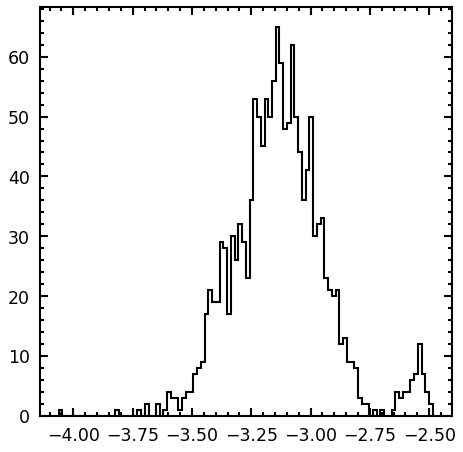

In [51]:
# Find identical Deem frameworks
D_deem = pairwise_distances(deem_soaps, metric='euclidean')

plt.hist(np.log10(D_deem[np.triu_indices(D_deem.shape[0], k=1)]), histtype='step', bins=100)
plt.show()

In [52]:
# Find closest IZA frameworks to all Deem frameworks
D = pairwise_distances(deem_soaps, iza_soaps, metric='euclidean')
D_min_idxs = np.argmin(D, axis=1)

In [53]:
# Print some extra info for the above Deem frameworks
# in a format we can copy and paste into a LaTeX table
class_key = {1: 'IZA1', 2:'IZA2', 3:'IZA3', 4:'Deem'}
select_deem_codes = deem_codes[deem_vertices_df_de - n_iza]
select_deem_de = de[deem_vertices_df_de]
select_deem_dfs_2 = dfs_2[deem_vertices_df_de]
select_deem_cantons_4 = predicted_deem_cantons_4[deem_vertices_df_de - n_iza]

# Sort
select_sort_idxs = np.argsort(select_deem_de)

# TODO: how to handle the Deem classified as Deem in the 4-class?
for idx, (deem_code, hull_distance, dec_func, canton, iza_code, iza_canton) in enumerate(zip(
    select_deem_codes[select_sort_idxs],
    select_deem_de[select_sort_idxs],
    select_deem_dfs_2[select_sort_idxs],
    [class_key[canton] for canton in select_deem_cantons_4[select_sort_idxs]],
    iza_codes[D_min_idxs][select_sort_idxs],
    iza_cantons[D_min_idxs][select_sort_idxs]
)):
    print(f'({idx+1:2d}) & {deem_code} & ${hull_distance:0.2e}$ & {dec_func:0.2f} & {canton} & {iza_code} (IZA{iza_canton}) \\\\')

( 1) & 8283748 & $0.00e+00$ & -4.57 & IZA2 & VET (IZA1) \\
( 2) & 8116170 & $0.00e+00$ & -0.98 & IZA2 & SIV (IZA3) \\
( 3) & 8323902 & $5.35e-04$ & -1.77 & IZA2 & PON (IZA3) \\
( 4) & 8327215 & $6.24e-04$ & -1.15 & IZA2 & GIU (IZA2) \\
( 5) & 8134478 & $1.44e-03$ & -1.07 & IZA2 & AWO (IZA3) \\
( 6) & 8221491 & $1.55e-03$ & -1.03 & IZA3 & AFI (IZA3) \\
( 7) & 8167606 & $1.57e-03$ & -0.16 & IZA3 & PON (IZA3) \\
( 8) & 8143025 & $1.64e-03$ & -0.60 & IZA1 & SEW (IZA2) \\
( 9) & 8074186 & $1.75e-03$ & -0.82 & IZA2 & ATT (IZA3) \\
(10) & 8103338 & $1.76e-03$ & -0.47 & IZA2 & PON (IZA3) \\
(11) & 8237027 & $1.87e-03$ & -0.54 & IZA3 & AWO (IZA3) \\
(12) & 8301632 & $1.88e-03$ & -0.74 & IZA2 & ITH (IZA1) \\
(13) & 8328191 & $2.83e-03$ & -0.58 & IZA3 & PSI (IZA3) \\
(14) & 8259213 & $2.87e-03$ & -0.25 & IZA2 & AWO (IZA3) \\
(15) & 8213076 & $3.12e-03$ & -0.61 & IZA2 & AWO (IZA3) \\
(16) & 8108288 & $3.12e-03$ & -0.05 & IZA3 & APD (IZA3) \\
(17) & 8264181 & $3.15e-03$ & -0.47 & IZA2 & MSO (IZA2) 

# Build a chemiscope

In [54]:
# All IZA frames in test set, Deem frames within 1 kJ/mol of the hull
chemiscope_de_limit = 1.0
chemiscope_deem_idxs = np.nonzero(de <= chemiscope_de_limit)[0]
chemiscope_deem_idxs = chemiscope_deem_idxs[chemiscope_deem_idxs >= n_iza]
chemiscope_deem_frames = [deepcopy(frames[i]) for i in chemiscope_deem_idxs]

chemiscope_iza_frames = deepcopy(frames[0:n_iza])
chemiscope_iza_idxs = np.arange(0, n_iza)

chemiscope_frames = chemiscope_iza_frames + chemiscope_deem_frames
chemiscope_idxs = np.concatenate((chemiscope_iza_idxs, chemiscope_deem_idxs))

# Strip the properties from the frames, we will set them manually
for frame in chemiscope_frames:
    frame.info = {}

In [55]:
def int_class_to_str(class_ints, n_classes=2):
    conversion_dict = {
        2: {1: 'IZA', 2:'Deem'},
        4: {1: 'IZA1', 2:'IZA2', 3:'IZA3', 4:'Deem'}
    }
    return np.array([conversion_dict[n_classes][c] for c in class_ints])

In [56]:
# Also 2 and 4 class decision function values
chemiscope_properties = dict(
    codes=dict(target='structure', values=codes[chemiscope_idxs]),
    projection=dict(target='structure', values=T[chemiscope_idxs, 0:2]),
    energies=dict(target='structure', values=energies[chemiscope_idxs]),
    volumes=dict(target='structure', values=volumes[chemiscope_idxs]),
    vertex=dict(target='structure', values=vertex_indicators[chemiscope_idxs]),
    true_class_2=dict(target='structure', values=int_class_to_str(cantons_2[chemiscope_idxs])),
    true_class_4=dict(target='structure', values=int_class_to_str(cantons_4[chemiscope_idxs], n_classes=4)),
    predicted_class_2=dict(target='structure', values=int_class_to_str(predicted_cantons_2[chemiscope_idxs])),
    predicted_class_4=dict(target='structure', values=int_class_to_str(predicted_cantons_4[chemiscope_idxs], n_classes=4)),
    decision_function_2=dict(target='structure', values=dfs_2[chemiscope_idxs]),
    decision_function_4=dict(target='structure', values=dfs_4[chemiscope_idxs]),
    hull_distance=dict(target='structure', values=d[chemiscope_idxs]),
    hull_distance_energy=dict(target='structure', values=de[chemiscope_idxs]),
    Si_fraction=dict(target='structure', values=Si_fraction[chemiscope_idxs])
)

In [57]:
chemiscope.write_input(
    f'{gch_dir}/svm-pcovr-gch_chemiscope{mixing}.json.gz', 
    chemiscope_frames, 
    meta=dict(name='SVM-PCovR-GCH'),
    properties=chemiscope_properties,
    cutoff=None
)

## Plot the "chemiscope"

In [ ]:
with gzip.GzipFile(f'{gch_dir}/svm-pcovr-gch_chemiscope.json.gz', 'r') as f:
    data = json.load(f)

In [ ]:
T1 = np.array(data['properties']['projection[1]']['values'])
T2 = np.array(data['properties']['projection[2]']['values'])
E = np.array(data['properties']['energies']['values'])
hull_distance = np.array(data['properties']['hull_distance']['values'])
hull_distance_energy = np.array(data['properties']['hull_distance_energy']['values'])
true_class = np.array(data['properties']['true_class_2']['values'])
predicted_class = np.array(data['properties']['predicted_class_2']['values'])

In [ ]:
symbols = []
for t in true_class:
    if t == 'DEEM':
        symbols.append('circle')
    elif t == 'IZA1':
        symbols.append('square')
    elif t == 'IZA2':
        symbols.append('diamond')
    elif t == 'IZA3':
        symbols.append('cross')

In [ ]:
classes = sorted(list(set(true_class)))

In [ ]:
fig = go.Figure()

for t, s in zip(classes, ('circle', 'square', 'diamond', 'cross')):
    X = T1[true_class == t]
    Y = T2[true_class == t]
    Z = E[true_class == t]
    HDE = hull_distance_energy[true_class == t]
    fig.add_trace(go.Scatter3d(x=X, y=Y, z=Z, mode='markers',
                               marker=dict(color=HDE,
                                           coloraxis='coloraxis',
                                           line_width=1,
                                           size=3,
                                           symbol=s),
                              name=t))

fig.update_layout(template='plotly_white',
                  scene=dict(xaxis_title='T<sub>1</sub>',
                             yaxis_title='T<sub>2</sub>',
                             zaxis_title='Energy per Si<br>(kJ/mol Si)'),
                  legend=dict(x=0.0, y=1.0,
                              xanchor='left', yanchor='top',
                              itemsizing='constant'),
                  coloraxis=dict(colorscale='Plasma',
                                 colorbar=dict(title='Hull Distance<br>(kJ/mol)')),
                  autosize=False,
                  width=600, height=600)

fig.show()
#fig.write_image('../../Results/6.0/SVM-KPCovR-GCH.png')